In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', 200)

In [2]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, precision_recall_curve, accuracy_score

In [3]:
Ks = [50, 100, 200]

In [4]:
imbalance = 108 / (2457+108)

In [5]:
models = ['svm_lin', 'svm_rbf', 'cnn_lstm', 'tf_init', 'tf_frozen', 'tf_finetuned']
model_colors = {'svm_lin': 'gold', 'svm_rbf': 'orange', 'cnn_lstm': 'lightgreen', 'tf_init': 'lightskyblue', 'tf_frozen': 'lightsteelblue', 'tf_finetuned': sns.color_palette('tab10')[0], }
model_name = {'svm_lin': 'SVM (linear)', 'svm_rbf': 'SVM (RBF)', 'cnn_lstm': 'CNN-LSTM', 'tf_init': 'TF init BB', 'tf_frozen': 'TF frozen BB', 'tf_finetuned': 'TF fine-tuned BB', }

### Read data and some transformations and numbers for the paper

In [6]:
predictions = pd.read_csv('prediction_values_all_models.csv.zip', index_col=0)

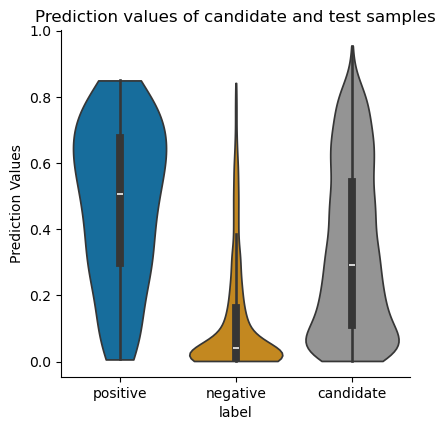

In [7]:
plt.figure(figsize=(4.5, 4.5))
test_and_candidate_set = predictions[(predictions['label'] == 'candidate') | (predictions['group_split_0'] == 'test')].copy()
sns.violinplot(test_and_candidate_set, x='label', order=['1.0', '0.0', 'candidate'], y='tf_finetuned_ensemble', hue='label', hue_order=['0.0', '1.0', 'candidate'], cut=0, 
               palette={'0.0': sns.color_palette('colorblind')[1], '1.0': sns.color_palette('colorblind')[0], 'candidate': sns.color_palette('colorblind')[7]})
sns.despine()
plt.title('Prediction values of candidate and test samples')
plt.xlabel('label')
plt.xticks(ticks=[0, 1, 2], labels=['positive', 'negative', 'candidate'])
plt.ylabel('Prediction Values')
plt.savefig('pred_distribution.pdf', bbox_inches='tight')
plt.savefig('pred_distribution.png', bbox_inches='tight', dpi=600)
plt.show()

### Metrics

In [8]:
results = []
for model in models:
    for i in list(range(5)) + ['ensemble']:
        config = f'{model}_{i}'
        result = {'config': config,
              'split': i,
              'ensemble': i == 'ensemble',
              'model': model,
             }
        # Without candidates
        prediction_subset = predictions[predictions['label'].isin(['1.0', '0.0'])]
        test_subset = prediction_subset[prediction_subset['group_split_0'] == 'test'].copy()
        result.update({
                  f'AUROC': roc_auc_score(test_subset['label'] == '1.0', test_subset[config]),
                  f'APS': average_precision_score(test_subset['label'] == '1.0', test_subset[config]),
                 })

        
        for K in Ks:
            test_subset_top_k = test_subset.loc[test_subset[config].nlargest(K).index]
            result.update({f'Precision@{K}': precision_score(test_subset_top_k['label'] == '1.0', np.ones_like(test_subset_top_k[config]))})
        
        
        precision_at_K = []
        for K in range(1, 200):
            test_subset_top_k = test_subset.loc[test_subset[config].nlargest(K).index]
            precision_at_K.append(precision_score(test_subset_top_k['label'] == '1.0', np.ones_like(test_subset_top_k[config])))
        result.update({f'Precision@K': precision_at_K})

        # ideal threshold
        if i == 'ensemble':
            val_subset = prediction_subset[prediction_subset[f'group_split_0'].isin(['train', 'val'])].copy()
        else:
            val_subset = prediction_subset[prediction_subset[f'group_split_{i}'] == 'val'].copy()
        precision, recall, thresholds = precision_recall_curve(val_subset['label'] == '1.0', val_subset[f'{model}_ensemble'])
        f1_scores = 2*precision*recall / (precision+recall)
        best_threshold = thresholds[f1_scores.argmax()]

        result.update({
                  f'Precision': precision_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'Recall': recall_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'F1-score': f1_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'ideal_threshold': best_threshold,
                 })
        results.append(result)

results = pd.DataFrame(results)

/var/folders/l3/n75m9_cn5lzbx_tm88xrzhmhcfmwpj/T/ipykernel_52434/1385772145.py:36: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*precision*recall / (precision+recall)
/var/folders/l3/n75m9_cn5lzbx_tm88xrzhmhcfmwpj/T/ipykernel_52434/1385772145.py:36: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*precision*recall / (precision+recall)
/Users/yang.an/mamba/envs/tf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


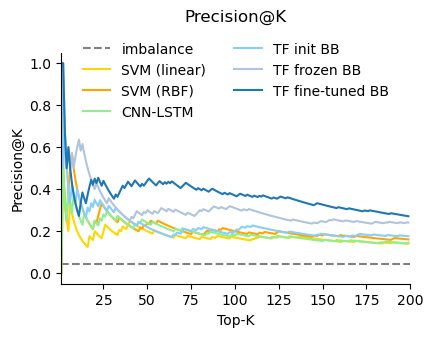

In [9]:
ensemble_results = results[results['config'].str.contains('ensemble')]

plt.figure(figsize=(4.5, 3))
plt.axhline(imbalance, label='imbalance', c='grey', ls='--')
for model in model_colors.keys():
    sns.lineplot(x=range(1, 200), y=ensemble_results[ensemble_results['model'] == model]['Precision@K'].item(), label=model_name[model], color=model_colors[model])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=2, frameon=False)
plt.ylabel('Precision@K')
plt.xlabel('Top-K')
plt.xlim(1, 200)
plt.title('Precision@K', y=1.1)
sns.despine()
plt.savefig('Precision@200.pdf', bbox_inches='tight')
plt.savefig('Precision@200.png', bbox_inches='tight', dpi=600)
plt.show()

In [10]:
results_ensemble = results[results['ensemble']].copy()
results_ensemble = results_ensemble[['config'] + [f'{metric}' for metric in ['AUROC', 'APS', 'F1-score', 'Precision', 'Recall']] + [f'Precision@{K}' for K in Ks]]
results_ensemble.round(2)

,config,AUROC,APS,F1-score,Precision,Recall,Precision@50,Precision@100,Precision@200
5,svm_lin_ensemble,0.67,0.11,0.16,0.17,0.15,0.20,0.17,0.14
11,svm_rbf_ensemble,0.74,0.14,0.21,0.20,0.23,0.24,0.20,0.16
17,cnn_lstm_ensemble,0.78,0.14,0.21,0.15,0.35,0.24,0.18,0.14
23,tf_init_ensemble,0.79,0.16,0.23,0.18,0.30,0.22,0.20,0.18
29,tf_frozen_ensemble,0.87,0.25,0.31,0.23,0.47,0.30,0.31,0.24
35,tf_finetuned_ensemble,0.89,0.30,0.38,0.34,0.44,0.44,0.37,0.28


In [11]:
cols = [f'{metric}' for metric in ['AUROC', 'APS', 'Precision', 'Recall', 'F1-score']]
cols += ['ideal_threshold']
cols += [f'Precision@{K}' for K in [50, 100, 200]]
results_without_ensemble = results[~results['ensemble']].copy()
results_without_ensemble = results_without_ensemble.melt(id_vars=['model'], value_vars=cols)

results_without_ensemble.groupby(['model', 'variable']).describe()['value'][['mean', 'std']].apply(lambda x: f"{x['mean']:.2f}±{x['std']:.2f}", axis=1).to_frame().reset_index().rename(columns={0: 'value'})\
.pivot(index='model', columns='variable', values='value')[['AUROC', 'APS', 'F1-score', 'Precision', 'Recall'] + [f'Precision@{K}' for K in Ks]]\
.reindex(models)

variable,AUROC,APS,F1-score,Precision,Recall,Precision@50,Precision@100,Precision@200
model,,,,,,,,
svm_lin,0.65±0.01,0.10±0.01,0.15±0.04,0.16±0.05,0.15±0.07,0.18±0.05,0.15±0.03,0.13±0.01
svm_rbf,0.74±0.01,0.13±0.02,0.19±0.03,0.19±0.02,0.20±0.06,0.20±0.03,0.19±0.01,0.15±0.01
cnn_lstm,0.77±0.00,0.13±0.01,0.14±0.09,0.12±0.09,0.38±0.33,0.18±0.08,0.16±0.02,0.14±0.01
tf_init,0.78±0.01,0.14±0.02,0.15±0.06,0.17±0.07,0.37±0.29,0.20±0.05,0.16±0.04,0.15±0.02
tf_frozen,0.86±0.02,0.23±0.04,0.26±0.04,0.22±0.06,0.46±0.24,0.28±0.06,0.24±0.05,0.22±0.03
tf_finetuned,0.87±0.01,0.27±0.01,0.25±0.12,0.40±0.34,0.39±0.27,0.37±0.03,0.32±0.02,0.26±0.01


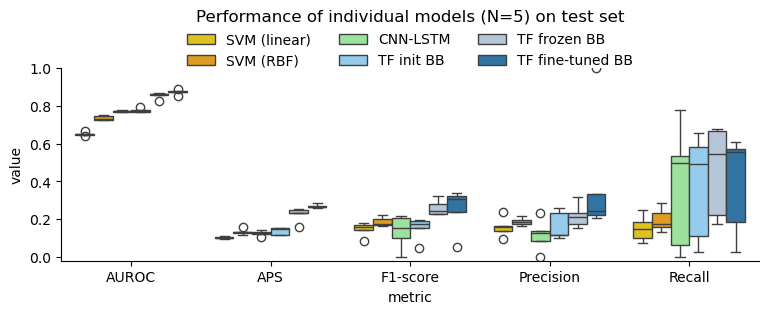

In [12]:
plt.figure(figsize=(9, 2.5))
results_without_ensemble = results[~results['ensemble']].copy()
results_without_ensemble = results_without_ensemble.melt(id_vars=['model'], value_vars=[f'{metric}' for metric in ['AUROC', 'APS', 'F1-score', 'Precision', 'Recall']])
results_without_ensemble['metric'] = results_without_ensemble['variable']
results_without_ensemble['model_name'] = results_without_ensemble['model'].replace(model_name)
ax = sns.boxplot(results_without_ensemble,
                x='metric',
                y='value', 
                hue='model_name', 
                 hue_order=['SVM (linear)', 'SVM (RBF)', 'CNN-LSTM', 'TF init BB', 'TF frozen BB', 'TF fine-tuned BB'], 
                palette={v: model_colors[k] for k, v in model_name.items()},
                )
sns.move_legend(ax, 'upper center', ncols=3, bbox_to_anchor=(0.5, 1.25), frameon=False, title='')
plt.ylim(-0.02, 1.0)
sns.despine()
plt.title(f'Performance of individual models (N=5) on test set', y=1.2)
plt.savefig('benchmark.pdf', bbox_inches='tight')
plt.savefig('benchmark.png', bbox_inches='tight', dpi=600)
plt.show()